# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!

# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
current_palette = sns.color_palette()

# Functions

### Wide Format Zillow Data to Long Format

In [2]:
def pulling_time_columns(dataframe, time_start_column=7):
    """
    Input- Entry zillow data with time series columns. Optional the order of column the time series starts.
    Output- List of time series columns.
    """
    return list(dataframe.columns[time_start_column:])

def pulling_non_time_columns(dataframe, time_start_column=7):
    """
    Input- Entry zillow data with time series columns. Optional the order of column the time series starts.
    Output- List of non time series columns.
    """
    return list(dataframe.columns[:time_start_column])

def dataframe_to_dict(dataframe, columns, type_='records'):
    """
    Input- Entry dataframe. Optional type of dictionary needed
    Output-Output list of dictionaries with columns as the keys.
    """
    return dataframe[columns].to_dict(type_)

def update_dict_wide_to_long(dataframe, value_name= 'Value'):
    """
    Input- Entry zillow data with time series columns. 
    Output- Output list of dictionaries with columns as the keys.
    """
    df_dict = []
    for column in pulling_time_columns(dataframe):
        non_time_series_columns_dict = dataframe_to_dict(dataframe,pulling_non_time_columns(dataframe))
        for j,i in enumerate(dataframe[column]):
            non_time_series_columns_dict[j].update({value_name:i, 'Time':pd.to_datetime(column, format='%Y-%m')})
            df_dict.append(non_time_series_columns_dict[j])
    return df_dict
        
def convert_dict_back_dataframe(df_dict):
    """
    Input- Entry list of dictionaries 
    Output- Dataframe.
    """
    return pd.DataFrame(df_dict).set_index('Time')

def dataframe_wide_to_long(dataframe):
    """
    Input- Entry zillow data with time series columns in  wide format.
    Output- Dataframe in long format.
    """
    return convert_dict_back_dataframe(update_dict_wide_to_long(dataframe))

### Dataframe Column Manipulation 

In [3]:
def splitting_pulling_text_dataseries(dataseries, text_= ',', split = 0, start = 0, end = None):
    """
    Input- Dataseries with a piece of text that can be uniformly split all the data points
        Optional- Spliting text
                - starting 
    Output- List of spliced strings
    """
    return [x.split(text_)[split][start:end] for x in dataseries.values]

def splice_dataseries_text(dataseries, start = 0, end = None):
    """
    Input- Dataseries with a piece of text that can be uniformly split all the data points
        Optional- Spliting text
                - starting 
    Output- List of spliced strings
    """
    return [x[start:end] for x in dataseries.values]

def dataframe_column_difference(old, new):
    """
    Input- Two numerical dataseries  
    Output- Dataseries of differences
    """
    return new-old

def dataframe_column_percent_difference(old, new):
    """
    Input- Two numerical dataseries  
    Output- Dataseries of percent difference
    """
    return dataframe_column_difference(old, new)/old

# Step 1: Load the Data/Filtering for Chosen Zipcodes

#### Loading Zillow Data

In [4]:
df_zillow =pd.read_csv('zillow_data.csv')
df_zillow.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

#### Setting Up Metro Area Population Dataframe 

In [5]:
df_pop = pd.read_excel('PEP_2018_PEPANNRES_with_ann.xlsx', header=0)
df_pop['State'] =splitting_pulling_text_dataseries(df_pop.Geography, split=1, start=1, end=3)
df_pop['City'] =splitting_pulling_text_dataseries(df_pop.Geography)
df_pop['2010_2018_increase'] = dataframe_column_difference(df_pop.POP_JULY_1_2010, df_pop.POP_JULY_1_2018)
df_pop['Area'] = splitting_pulling_text_dataseries(df_pop.Geography, text_= '*', start=-10, end= -5)
df_pop['2010_2018_%'] = splice_dataseries_text(df_pop.Geography, start=-10, end= -5)

#### Top Metro Areas

In [6]:
number_metro_areas= 1
area = 'Metro'
top_metro_dict = df_pop.loc[(df_pop.Area == area) & (df_pop.POP_JULY_1_2018 >= 1000000)].sort_values('2010_2018_%',
                                        ascending=False)[:number_metro_areas][['City', 'State']].to_dict('records')
metro_areas = []
index = 0
for i in top_metro_dict:
    for j in i['City'].split('-'):
        print(f"{index+ 1}. {j}, {i['State']}")
        index +=1
        metro_areas.append({'City':j, 'State':i['State']})

1. Atlanta, GA
2. Sandy Springs, GA
3. Roswell, GA


#### Find Index

In [7]:
index_list = []
for i in metro_areas:
    
    ind = list(df_zillow.loc[(df_zillow.City.apply(lambda x: x in i['City'])) 
                        & (df_zillow.State == i['State'])][pulling_non_time_columns(df_zillow)].index)
    print(f"{i['City']}, {i['State']}- {len(ind)}")
    index_list = np.append(index_list, ind)
df_metro_ = df_zillow.iloc[index_list]

Atlanta, GA- 12
Sandy Springs, GA- 3
Roswell, GA- 2


In [8]:
df_zillow.loc[(df_zillow.State == 'MS') & (df_zillow.City.apply(lambda x: 'Meridian' in x))]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


# Step 2: Data Preprocessing

In [9]:
data = dataframe_wide_to_long(df_metro_)
print(data.info())
print(data.City.nunique())
print(data.groupby(['City', 'State']).count())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4505 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
City          4505 non-null object
CountyName    4505 non-null object
Metro         4505 non-null object
RegionID      4505 non-null int64
RegionName    4505 non-null int64
SizeRank      4505 non-null int64
State         4505 non-null object
Value         4505 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 316.8+ KB
None
3
                     CountyName  Metro  RegionID  RegionName  SizeRank  Value
City          State                                                          
Atlanta       GA           3180   3180      3180        3180      3180   3180
Roswell       GA            530    530       530         530       530    530
Sandy Springs GA            795    795       795         795       795    795


# Step 3: EDA and Visualization

In [10]:
zips = data.groupby('RegionName')['Value'].median().sort_values(ascending=False).index[:10]


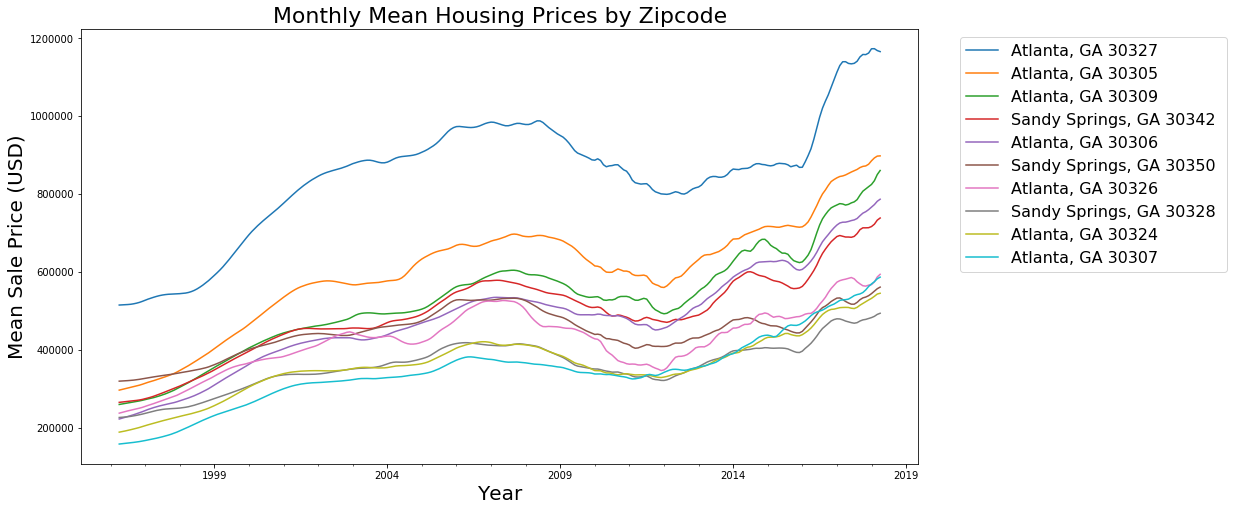

In [11]:
for zipcode in zips:
    temp_df = data[data.RegionName == zipcode]
    temp_df['Value'].plot(figsize=(15,8), label=f"{temp_df.City[0]}, {temp_df.State[0]} {zipcode} ")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1, fontsize=16)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Mean Sale Price (USD)", fontsize=20)
plt.title("Monthly Mean Housing Prices by Zipcode", fontsize=22);


In [22]:
df = df_zillow.loc[df_zillow.Metro == 'Knoxville']
df.groupby('City')['RegionName'].count()

City
Alcoa              1
Andersonville      1
Blaine             1
Caryville          1
Clinton            1
Corryton           1
Deer Lodge         1
Farragut           1
Friendsville       1
Greenback          1
Harriman           1
Heiskell           1
Jacksboro          1
Jellico            1
Kingston           1
Knoxville         14
Lafollette         1
Lake City          1
Lancing            1
Lenoir City        2
Loudon             1
Louisville         1
Luttrell           1
Maryville          3
Mascot             1
Maynardville       1
Oak Ridge          1
Oakdale            1
Oliver Springs     1
Philadelphia       1
Pioneer            1
Powell             1
Rockford           1
Rockwood           1
Rutledge           1
Sharps Chapel      1
Sunbright          1
Townsend           1
Walland            1
Wartburg           1
Washburn           1
Name: RegionName, dtype: int64

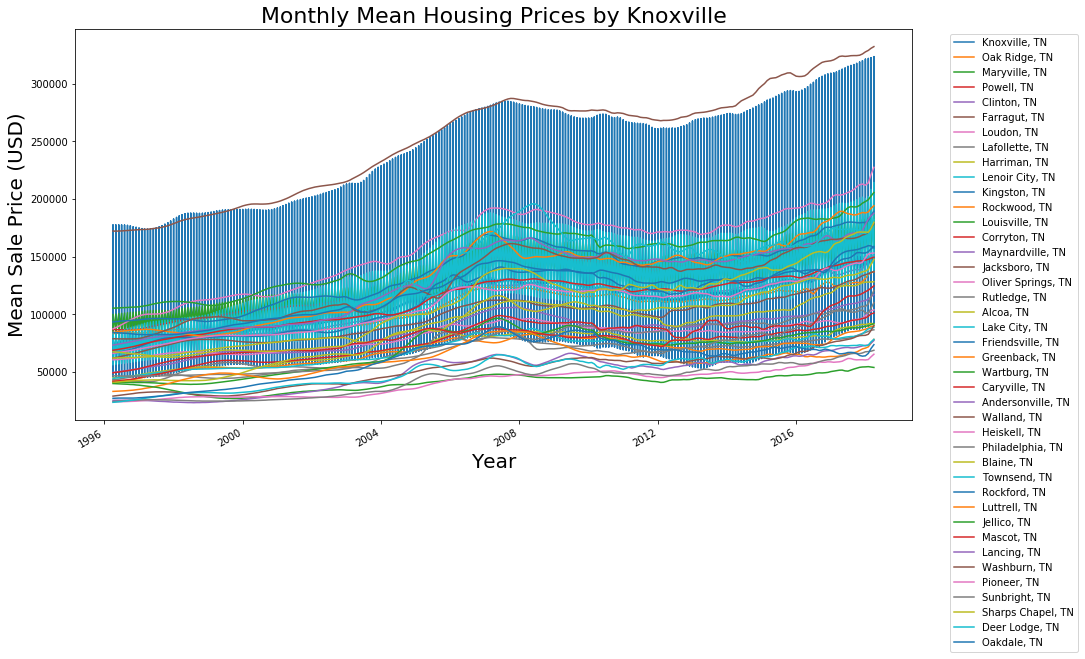

In [23]:

data = dataframe_wide_to_long(df)
for city in data.City.unique():
    temp_df = data[data.City == city]
    temp_df['Value'].plot(figsize=(15,8), label=f"{temp_df.City[0]}, {temp_df.State[0]}")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Mean Sale Price (USD)", fontsize=20)

plt.title(f"Monthly Mean Housing Prices by {temp_df.Metro[0]}", fontsize=22);


In [17]:
count= 0 
for city in data.sort_values('City').City.unique():
    
    for zip in data.loc[city].RegionName.unique():
        temp_df = data[data.RegionName == zip]
        temp_df['Value'].plot(figsize=(15,8), label=f"{temp_df.City[0]}, {temp_df.State[0]} {zip}")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Mean Sale Price (USD)", fontsize=20)

plt.title(f"Monthly Mean Housing Prices by {temp_df.Metro[0]}", fontsize=22);

KeyError: 'the label [Alcoa] is not in the [index]'

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted = melted.set_index('time')
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

In [ ]:
current_palette = sns.color_palette()

In [16]:
current_palette[1]

(1.0, 0.4980392156862745, 0.054901960784313725)

# Step 6: Interpreting Results